In [84]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm

In [2]:
######################
### Load meanbrain ###
######################

luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke_lowres.nii"
luke = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')

########################################
### Load warp params and fixed brain ###
########################################

fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed = ants.resample_image(fixed,(256,128,49),1,interp_type=1) #nearest neighbor

affine_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke-to-jrc2018_fwdtransforms_lowres/tmps47el_wi0GenericAffine.mat"

# Prep voxel-res corr map

In [35]:
################################
### Load voxel-res corr data ###
################################

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    r_map[p_map >= 1e-4]=0
    
    maps[behavior] = r_map

In [56]:
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49):
    colors1 = maps['Z_neg'][z,:,:].T
    colors2 = maps['Z_pos'][z,:,:].T
    colors3 = maps['Y_pos'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)

func = np.swapaxes(slices, 0, 2)
func.shape

res_LUKE = (2.6, 2.6, 5, 1)
moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing(res_LUKE)

In [57]:
############
### Warp ###
############

maps_voxel_res = ants.apply_transforms(fixed, moving, affine_file, imagetype=3, interpolator='nearestNeighbor')
maps_voxel_res = maps_voxel_res.numpy()

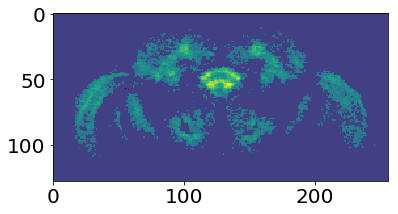

In [58]:
plt.imshow(maps_voxel_res[:,:,27,2].T)

# Prep super-voxel-res corr map

In [7]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210101_correlation/"

In [8]:
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000.npy'
cluster_model_labels = np.load(labels_file)

In [9]:
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    final_map = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]

            if p_map[z,cluster_num] <= 1e-8 :
                sig = 1
            else:
                sig = 0

            if len(cluster_indicies) > 100:
                sig = np.nan
            colored_by_betas[cluster_indicies] = r_map[z,cluster_num]*sig
        colored_by_betas = colored_by_betas.reshape(256,128)
        final_map.append(colored_by_betas)
    final_map = np.asarray(final_map)
    maps[behavior] = final_map

In [24]:
norm_min = 0
norm_max = np.max(np.nan_to_num(maps['Y_pos']))
norm_max = 0.15
slices = []
for z in range(49):
    colors1 = Normalize(norm_min, norm_max)(maps['Z_neg'][z,:,:].T)
    colors2 = Normalize(norm_min, norm_max)(maps['Z_pos'][z,:,:].T)
    colors3 = Normalize(norm_min, norm_max)(maps['Y_pos'][z,:,:].T)
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)    

In [25]:
slices = np.moveaxis(slices,0,2)
slices = np.swapaxes(slices,0,1)
slices.shape

(256, 128, 49, 3)

In [26]:
res_LUKE = (2.6, 2.6, 5, 1)
moving = ants.from_numpy(slices[:,:,::-1,:])
moving.set_spacing(res_LUKE)

In [30]:
############
### Warp ###
############

maps_spvox_res = ants.apply_transforms(fixed, moving, affine_file, imagetype=3, interpolator='nearestNeighbor')
maps_spvox_res = maps_spvox_res.numpy()

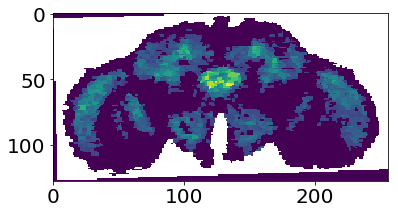

In [39]:
plt.imshow(maps_spvox_res[:,:,27,2].T)

# Make video

In [61]:
maps_spvox_res.shape, maps_voxel_res.shape

((256, 128, 49, 3), (256, 128, 49, 3))

In [59]:
##################
### Alpha Mask ###
##################

def alpha_mask_zeros(to_mask):
    avg_value = np.mean(np.nan_to_num(to_mask),axis=-1)
    mask = np.zeros(np.shape(avg_value))
    mask[np.where(avg_value>0)] = 1
    to_plot = np.concatenate((to_mask, mask[:,:,:,np.newaxis]),axis=-1)
    return to_plot

spvox_to_plot = alpha_mask_zeros(maps_spvox_res)
vox_to_plot = alpha_mask_zeros(maps_voxel_res)

  6%|▌         | 3/49 [00:00<00:14,  3.25it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  8%|▊         | 4/49 [00:01<00:14,  3.19it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 10%|█         | 5/49 [00:01<00:14,  3.02it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 12%|█▏        | 6/49 [00:02<00:15,  2.85it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for ims

 65%|██████▌   | 32/49 [00:31<00:20,  1.18s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 67%|██████▋   | 33/49 [00:33<00:19,  1.24s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 69%|██████▉   | 34/49 [00:34<00:18,  1.26s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 71%|███████▏  | 35/49 [00:35<00:17,  1.28s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for

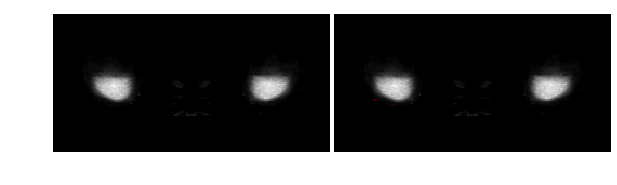

In [86]:
plt.figure(figsize=(10,10))

for z in tqdm(range(49)):
    plt.subplot(121)
    plt.imshow(luke[:,:,z].T,cmap='gray')
    plt.imshow(np.swapaxes(spvox_to_plot[:,:,z,:]*2,0,1))
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(luke[:,:,z].T,cmap='gray')
    plt.imshow(np.swapaxes(vox_to_plot[:,:,z,:]*20,0,1))
    plt.axis('off')

    plt.subplots_adjust(wspace=0.02)
    
    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210620_corr_video'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    label = format(z, '02d')
    fname = os.path.join(save_path, f'{label}')
    plt.savefig(fname,dpi=100,bbox_inches='tight')

# Load mirror-cleaned

In [87]:
load_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210427_anat_midline_flip/final2.nii"
corrs = np.array(nib.load(load_file).get_data(), copy=True)
corrs = np.swapaxes(corrs,2,3)
corrs.shape

(256, 128, 49, 3)

In [88]:
mirror_to_plot = alpha_mask_zeros(corrs)

In [92]:
mirror_to_plot.shape

(256, 128, 49, 4)

In [93]:
mirror_to_plot_rg_flip = mirror_to_plot.copy()
mirror_to_plot_rg_flip[...,0] = mirror_to_plot[...,1]
mirror_to_plot_rg_flip[...,1] = mirror_to_plot[...,0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

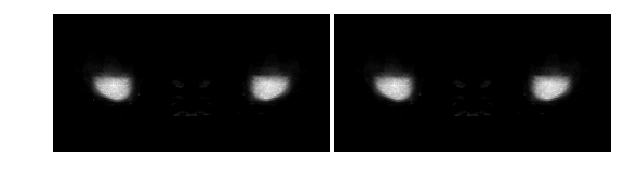

In [96]:
plt.figure(figsize=(10,10))
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210620_corr_video_2'

for z in range(49):
    plt.subplot(121)
    plt.imshow(luke[:,:,z].T,cmap='gray')
    plt.imshow(np.swapaxes(vox_to_plot[:,:,z,:]*20,0,1))
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(luke[:,:,z].T,cmap='gray')
    plt.imshow(np.swapaxes(mirror_to_plot_rg_flip[:,:,z,:]*2,0,1))
    plt.axis('off')

    plt.subplots_adjust(wspace=0.02)

    timestr = time.strftime("%Y%m%d-%H%M%S")
    label = format(z, '02d')
    fname = os.path.join(save_path, f'{label}')
    plt.savefig(fname,dpi=100,bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


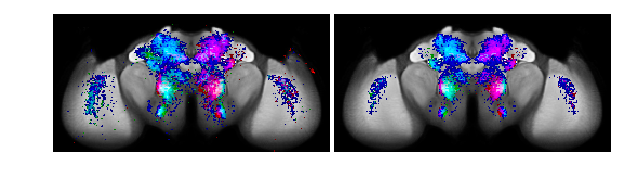

In [95]:
plt.figure(figsize=(10,10))
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20210620_corr_video_2'

z=20
plt.subplot(121)
plt.imshow(luke[:,:,z].T,cmap='gray')
plt.imshow(np.swapaxes(vox_to_plot[:,:,z,:]*20,0,1))
plt.axis('off')

plt.subplot(122)
plt.imshow(luke[:,:,z].T,cmap='gray')
plt.imshow(np.swapaxes(mirror_to_plot_rg_flip[:,:,z,:]*2,0,1))
plt.axis('off')

plt.subplots_adjust(wspace=0.02)

timestr = time.strftime("%Y%m%d-%H%M%S")
label = format(z, '02d')
fname = os.path.join(save_path, f'{label}')
#plt.savefig(fname,dpi=100,bbox_inches='tight')